In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
if False:
  %cd /content/drive/MyDrive/ml-project-2-roadmen-bruv/
if False:
  %cd "/content/drive/MyDrive/ML_google_colab/Project 2/ml-project-2-roadmen-bruv"
if True:
  %cd "/content/drive/MyDrive/EPFL/MachineLearningMA3/ml-project-2-roadmen-bruv"
  # %cd "/content/drive/MyDrive/ml-project-2-roadmen-bruv"

/content/drive/MyDrive/EPFL/MachineLearningMA3/ml-project-2-roadmen-bruv


## Libraries

In [ ]:
from IPython.display import clear_output
!pip install git+https://github.com/qubvel/segmentation_models.pytorch
!pip install -U albumentations
clear_output()

In [ ]:
import sys
sys.path.append("./utils")
sys.path.append("./helpers")

In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import segmentation_models_pytorch as smp
from segmentation_models_pytorch import utils as smp_utils

import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os, sys
import torch
from PIL import Image
import albumentations as albu
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset
from PIL import Image
import pandas as pd
from mask_to_submission import masks_to_submission

# For alternative loss
import torch.nn as nn
import segmentation_models_pytorch.utils.base as base
import segmentation_models_pytorch.utils.functional as F
from segmentation_models_pytorch.base.modules import Activation

## Control board

In [ ]:
#Creates the necessary folders for saving results
model_weights_folder = './submissions/models/'
os.makedirs(model_weights_folder, exist_ok=True)

SUBMISSION_NAME = "submission_" + "test_run_new_loss2/"
submission_folder = './submissions/' + SUBMISSION_NAME
os.makedirs(submission_folder, exist_ok=True)

In [ ]:
PARAMS = {
  'MODELS' : ["UnetPlusPlus"], # Available : "Unet","DeepLabV3","FPN", "UnetPlusPlus"
  'ENCODER' : 'resnet34',
  'ENCODER_WEIGHTS' : 'imagenet',
  'NB_EPOCHS' : 15,
  'ACTIVATION' : 'sigmoid', # could be None for logits or 'softmax2d' for multiclass segmentation,
  'DATA_AUGMENTATION' : True, #choose whether the data is augmented to 900 images or use original dataset of 100 images,
  'CLASSES' : ['road'],
}


# 0) Data aug

In [ ]:
 create_aug_data = False

 if create_aug_data:
  # Create folders for data augmentation
  %mkdir data/data_train_augmented
  %mkdir data/data_train_augmented/images/
  %mkdir data/data_train_augmented/masks/
  %mkdir data/data_train_augmented/raw/
  %mkdir data/data_train_augmented/raw/images/
  %mkdir data/data_train_augmented/raw/masks/
  %mkdir data/data_validation
  %mkdir data/data_validation/images/
  %mkdir data/data_validation/masks/
  %mkdir data/data_validation/raw/
  %mkdir data/data_validation/raw/images/
  %mkdir data/data_validation/raw/masks/

  # Load images and masks from dataset
  PATH_IMG_TRAIN = "./data/training/images/"
  PATH_MASK_TRAIN = "./data/training/groundtruth/"
  img_train, mask_train = load_img_training(PATH_IMG_TRAIN, PATH_MASK_TRAIN)
  key_list = list(img_train.keys())
  key_list.sort()

  # Split the images for training/validation (+ store)
  training_ratio = 0.8
  seed = 1
  train_keys, val_keys = split_keys(np.array(key_list), training_ratio=training_ratio, seed=seed)

  PATH_TR_IMG_AUG_RAW = "./data/data_train_augmented/raw/images/"
  PATH_TR_MASK_AUG_RAW = "./data/data_train_augmented/raw/masks/"
  PATH_VAL_IMG_RAW = "./data/data_validation/raw/images/"
  PATH_VAL_MASK_RAW = "./data/data_validation/raw/masks/"

  store_images(img_train, train_keys, PATH_TR_IMG_AUG_RAW)
  store_images(mask_train, train_keys, PATH_TR_MASK_AUG_RAW)
  store_images(img_train, val_keys, PATH_VAL_IMG_RAW)
  store_images(mask_train, val_keys, PATH_VAL_MASK_RAW)

  MASK_THRESHOLD = 120
  SIZE_X = 416 #divisible by 32
  SIZE_Y = 416 #divisible by 32
  PATH_TR_IMG_AUG = "./data/data_train_augmented/images/"
  PATH_TR_MASK_AUG = "./data/data_train_augmented/masks/"
  PATH_VAL_IMG = "./data/data_validation/images/"
  PATH_VAL_MASK = "./data/data_validation/masks/"

  # Load validation images and resize
  img_val_raw, mask_val_raw = load_img_training(PATH_VAL_IMG_RAW, PATH_VAL_MASK_RAW)
  keys_val = list(img_val_raw.keys())
  resize_augment_store_dataset(img_val_raw, mask_val_raw, keys_val, SIZE_Y, SIZE_X, MASK_THRESHOLD, PATH_VAL_IMG, PATH_VAL_MASK, augment=False)

  # Load training images, resize and augment using geometric transformation (+ store)
  img_tr_raw, mask_tr_raw = load_img_training(PATH_TR_IMG_AUG_RAW, PATH_TR_MASK_AUG_RAW)
  keys_tr = list(img_tr_raw.keys())
  resize_augment_store_dataset(img_tr_raw, mask_tr_raw, keys_tr, SIZE_Y, SIZE_X, MASK_THRESHOLD, PATH_TR_IMG_AUG, PATH_TR_MASK_AUG, augment=True)

# I) Model training

## Dataset class definition

In [ ]:
class Dataset(BaseDataset):
  CLASSES = ['road', 'unlabelled']
  def __init__(self, images_dir, masks_dir=None, classes=None, augmentation=None, preprocessing=None, plot = False):
      if masks_dir == None:
        self.ids = range(1, 51)
        self.images_fps = [os.path.join(images_dir, f'test_{idx}/',f'test_{idx}.png') for idx in self.ids]
      else:
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
      self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids] if masks_dir is not None else None

      # convert str names to class values on masks
      if classes is not None:
          self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]

      self.augmentation = augmentation
      self.preprocessing = preprocessing
      # self.preprocessing = None
      self.plot = plot

  def __getitem__(self, i):

      # read data
      image = cv2.imread(self.images_fps[i])
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      image = cv2.resize(image, (416, 416))
      # initialize mask as None
      mask = None

      if self.masks_fps == None:
        print(self.images_fps[i])
        if self.augmentation:
          sample = self.augmentation(image=image)
          image = sample['image']
        if self.preprocessing:
            sample = self.preprocessing(image=image)
            image = sample['image']
        return self.images_fps[i], image

      else:
        mask = cv2.imread(self.masks_fps[i], 0)
        mask = cv2.resize(mask, (416, 416))
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        if i == 0 and self.plot:
          plt_img_hist(image, mask)
          plt_img(image, mask)
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        if i == 0 and self.plot:
          plt_img_hist(image, mask)
          plt_img(image, mask)
        if self.preprocessing:
              sample = self.preprocessing(image=image, mask=mask)
              image, mask = sample['image'], sample['mask']
        if i == 0 and self.plot:
          plt_img_hist(image, mask)
          plt_img(image, mask)
        return image, mask

  def __len__(self):
      return len(self.ids)

## Model definitions

In [ ]:
models = [[smp.create_model(model_name, encoder_name=PARAMS["ENCODER"], encoder_weights = PARAMS["ENCODER_WEIGHTS"], in_channels=3, classes=1),model_name] for model_name in PARAMS["MODELS"]]

preprocessing_fn = smp.encoders.get_preprocessing_fn(PARAMS["ENCODER"], PARAMS["ENCODER_WEIGHTS"])

## Data importation, preprocessing and evaluation metrics def

In [ ]:
def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform

    Args:
        preprocessing_fn (callbale): data normalization function
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose

    """

    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')

In [ ]:
PATH_TR_IMG_AUG_RAW = "./data/data_train_augmented/raw/images/"
PATH_TR_MASK_AUG_RAW = "./data/data_train_augmented/raw/masks/"
PATH_VAL_IMG_RAW = "./data/data_validation/raw/images/"
PATH_VAL_MASK_RAW = "./data/data_validation/raw/masks/"
PATH_TR_IMG_AUG = "./data/data_train_augmented/images/"
PATH_TR_MASK_AUG = "./data/data_train_augmented/masks/"
PATH_VAL_IMG = "./data/data_validation/images/"
PATH_VAL_MASK = "./data/data_validation/masks/"


#change paths for the training and validation datasets depending on wether we want data augmentation or not
if PARAMS["DATA_AUGMENTATION"]:
  training_path_img = PATH_TR_IMG_AUG
  training_path_mask = PATH_TR_MASK_AUG
  validation_path_img = PATH_VAL_IMG
  validation_path_mask = PATH_VAL_MASK
else:
  training_path_img = PATH_TR_IMG_AUG_RAW
  training_path_mask = PATH_TR_MASK_AUG_RAW
  validation_path_img = PATH_VAL_IMG_RAW
  validation_path_mask = PATH_VAL_MASK_RAW

#create training and validation datasets
train_dataset = Dataset(
    training_path_img,
    training_path_mask,
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=['road'])


valid_dataset = Dataset(
    validation_path_img,
    validation_path_mask,
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=["road"],
)

#create the loaders for both datasets
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=False)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False)

### Integration of patch based evaluation methods

In [ ]:
# Define the image crop function
def img_crop(im, h, w):
    list_patches = []
    imgwidth = im.shape[2]
    imgheight = im.shape[3]
    for i in range(0, imgheight, h):
        for j in range(0, imgwidth, w):
            im_patch = im[:, :, j:j+w, i:i+h]
            list_patches.append((im_patch, i, j))
    return list_patches

# Define the value to class conversion function
def value_to_class(v, threshold):
    v_mean = v.mean(dim=(2, 3))
    return (v_mean > threshold).float()

def normalize_tensor(tensor):
    N, _, _, _ = tensor.shape
    normalized_tensor = torch.zeros_like(tensor)
    for i in range(N):
        min_val = tensor[i].min()
        max_val = tensor[i].max()
        normalized_tensor[i] = (tensor[i] - min_val) / (max_val - min_val)
    return normalized_tensor

# Assuming predictions_tensor and ground_truths_tensor are the input 4D tensors
def patch_extraction(predictions_tensor, ground_truths_tensor, threshold_pred=0.25, threshold_gt=0.25, print = True, norm = True):
    # Resize dimensions
    TARGET_SIZE = 608
    predictions_tensor = F.interpolate(predictions_tensor, size=(TARGET_SIZE, TARGET_SIZE), mode='bilinear', align_corners=False)
    ground_truths_tensor = F.interpolate(ground_truths_tensor, size=(TARGET_SIZE, TARGET_SIZE), mode='bilinear', align_corners=False)

    PATCH_SIZE = 16
    N, C, H, W = predictions_tensor.shape
    num_patches_height = H // PATCH_SIZE
    num_patches_width = W // PATCH_SIZE

    # Initialize tensors to hold the mean values
    predictions_means = torch.zeros((N, C, num_patches_height, num_patches_width))
    ground_truths_means = torch.zeros((N, C, num_patches_height, num_patches_width))

    # Crop the images into patches and compute the mean values
    predictions_patches = img_crop(predictions_tensor, PATCH_SIZE, PATCH_SIZE)
    ground_truths_patches = img_crop(ground_truths_tensor, PATCH_SIZE, PATCH_SIZE)

    # Assign the mean values to the correct location in the tensors
    for patch, i, j in predictions_patches:
        patch_idx_height = i // PATCH_SIZE
        patch_idx_width = j // PATCH_SIZE
        predictions_means[:, :, patch_idx_height, patch_idx_width] = patch.mean(dim=(2, 3))

    for patch, i, j in ground_truths_patches:
        patch_idx_height = i // PATCH_SIZE
        patch_idx_width = j // PATCH_SIZE
        ground_truths_means[:, :, patch_idx_height, patch_idx_width] = patch.mean(dim=(2, 3))

    # Normalize ground truth means between 0 and 1
    if norm:
        predictions_means = normalize_tensor(predictions_means)

    # Apply threshold to determine class membership
    predictions_classes = (predictions_means > threshold_pred).float()
    ground_truths_classes = (ground_truths_means > threshold_gt).float()

    # Plot the mean images
    if print:
      fig, ax = plt.subplots(2, 2, figsize=(10, 5))
      ax[0, 0].imshow(predictions_means[0].squeeze().detach().numpy(), cmap='gray')  # Detach and convert to numpy
      ax[0, 0].set_title('Predictions Mean Patch')
      ax[0, 1].imshow(ground_truths_means[0].squeeze().detach().numpy(), cmap='gray')  # Detach and convert to numpy
      ax[0, 1].set_title('Ground Truths Mean Patch')
      ax[1, 0].imshow(predictions_classes[0].squeeze().detach().numpy(), cmap='gray')  # Detach and convert to numpy
      ax[1, 0].set_title('predictions_classes')
      ax[1, 1].imshow(ground_truths_classes[0].squeeze().detach().numpy(), cmap='gray')  # Detach and convert to numpy
      ax[1, 1].set_title('ground_truths_classes')
      plt.show()

      # Plot histograms
      plt.figure(figsize=(10, 5))
      plt.subplot(1, 2, 1)
      plt.hist(predictions_means[0].squeeze().detach().numpy().flatten(), bins=50, color='blue', alpha=0.7, label='Prediction Means')
      plt.title('Histogram of Prediction Means')
      plt.xlabel('Pixel Values')
      plt.ylabel('Frequency')
      plt.legend()

      plt.subplot(1, 2, 2)
      plt.hist(ground_truths_means[0].squeeze().detach().numpy().flatten(), bins=50, color='green', alpha=0.7, label='Ground Truth Means')
      plt.title('Histogram of Ground Truth Means')
      plt.xlabel('Pixel Values')
      plt.ylabel('Frequency')
      plt.legend()

      plt.tight_layout()
      plt.show()

    return predictions_classes, ground_truths_classes

In [ ]:
import torch
import torch.nn.functional as F
from torch.nn.modules.loss import _Loss
from typing import Optional, List

class CustomDiceLoss(_Loss):
    def __init__(
        self,
        log_loss: bool = False,
        from_logits: bool = True,
        smooth: float = 0.0,
        ignore_index: Optional[int] = None,
        eps: float = 1e-7,
        w_pix: float = 1.0,
        w_patch: float = 0.0,
    ):
        super(CustomDiceLoss, self).__init__()
        self.log_loss = log_loss
        self.from_logits = from_logits
        self.smooth = smooth
        self.ignore_index = ignore_index
        self.eps = eps
        self.w_pix = w_pix
        self.w_patch = w_patch
        print("CustomDiceLoss w_pix: ", w_pix)
        print("CustomDiceLoss w_patch: ", w_patch)

        # Assuming patch_extraction is a defined function
        self.patch_extraction = patch_extraction

    def forward(self, y_pred: torch.Tensor, y_true: torch.Tensor) -> torch.Tensor:
        # Extract patches
        y_pred_patch, y_true_patch = self.patch_extraction(y_pred, y_true)
        print(y_pred_patch.shape)
        # Compute losses
        loss_pixel = self.compute_loss(y_pred, y_true)
        loss_patch = self.compute_loss(y_pred_patch, y_true_patch)

        # Average the losses
        return (self.w_pix * loss_pixel + self.w_patch * loss_patch) / (self.w_pix + self.w_patch)

    def compute_loss(self, y_pred: torch.Tensor, y_true: torch.Tensor) -> torch.Tensor:
        if self.from_logits:
            y_pred = F.logsigmoid(y_pred).exp()

        bs = y_true.size(0)
        y_true = y_true.view(bs, 1, -1)
        y_pred = y_pred.view(bs, 1, -1)

        if self.ignore_index is not None:
            mask = y_true != self.ignore_index
            y_pred = y_pred * mask
            y_true = y_true * mask

        intersection = (y_pred * y_true).sum()
        total = y_pred.sum() + y_true.sum()
        if self.ignore_index is not None:
            total -= (mask.logical_not().sum() * 2)

        dice_score = (2. * intersection + self.smooth) / (total + self.smooth + self.eps)

        if self.log_loss:
            return -torch.log(dice_score)
        else:
            return 1.0 - dice_score

In [ ]:
## Composite metrics

class Custom_Fscore(base.Metric):
    def __init__(self, beta=1, eps=1e-7, threshold=0.5, activation=None, ignore_channels=None, w_pix = 1, w_patch = 1, **kwargs):
        super(Custom_Fscore,self).__init__(**kwargs)
        self.eps = eps
        self.beta = beta
        self.threshold = threshold
        self.activation = Activation(activation)
        self.ignore_channels = ignore_channels
        self.w_pix = w_pix
        self.w_patch = w_patch
        print("Fscore w_pix: ", w_pix)
        print("Fscore w_patch: ", w_patch)

    def forward(self, pr, gt):
        pr = self.activation(pr)
        pr_pix = pr
        gt_pix = gt
        pr_patch, gt_patch = patch_extraction(pr, gt)

        f_score_pix = smp_utils.metrics.Fscore(
            beta=self.beta,
            eps=self.eps,
            threshold=self.threshold,
            ignore_channels=self.ignore_channels,
        ).forward(pr_pix, gt_pix)

        f_score_patch = smp_utils.metrics.Fscore(
            beta=self.beta,
            eps=self.eps,
            threshold=self.threshold,
            ignore_channels=self.ignore_channels,
        ).forward(pr_patch, gt_patch)

        return (self.w_pix * f_score_pix + self.w_patch * f_score_patch) / (self.w_pix + self.w_patch)

In [ ]:
# Dice/F1 score - https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient
# IoU/Jaccard score - https://en.wikipedia.org/wiki/Jaccard_index

loss_fn = CustomDiceLoss(w_pix = w_pix, w_patch = w_patch)
loss_fn.__name__ = 'Custom_dice_loss'

metrics = [
      Custom_Fscore(w_pix = w_pix, w_patch = w_patch), ]

# loss_fn = CustomDiceLoss(w_pix, w_patch)
# loss_fn.__name__ = 'Custom_dice_loss'

# metrics = [
#       smp_utils.metrics.Fscore(), ]

## Visualizing pre-processed data

A la base, utile si on train juste le decoder, pas tout le modèle, mais on train tout le modèle. Vérifier si véritablement meilleure convergence?

In the code snippet you provided, the optimizer is set up to update parameters for the entire model, not just the decoder. This is indicated by the line:

```
optimizer = torch.optim.Adam([
    dict(params=model.parameters(), lr=0.0001),
])\
```



Here, model.parameters() refers to all the parameters of the model that will be updated during training. If only the decoder was being trained, the parameters would need to be specifically filtered to only include those of the decoder.

In [ ]:
def plt_img_hist(image, mask):
    # Set up the matplotlib figure and axes
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    # Plot the histogram for the image
    axs[0].hist(image.flatten(), bins=30, edgecolor='black', color='blue')
    axs[0].set_title('Image Histogram')
    axs[0].set_xlabel('Pixel Intensity')
    axs[0].set_ylabel('Frequency')

    # Plot the histogram for the mask
    axs[1].hist(mask.flatten(), bins=30, edgecolor='black', color='green')
    axs[1].set_title('Mask Histogram')
    axs[1].set_xlabel('Pixel Intensity')
    axs[1].set_ylabel('Frequency')

    # Display the plots
    plt.tight_layout()
    plt.show()


In [ ]:
def plt_img(image, mask):
    # Print the original dimensions
    print(f"Original image dimensions: {image.shape}")
    print(f"Original mask dimensions: {mask.shape}")

    # Plotting the image and mask
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    # Only transpose the image if it's not in the (height, width, channels) format
    if image.ndim == 3 and image.shape[-1] != 3:
        image = image.transpose((1, 2, 0))  # Reorder dimensions to (height, width, channels)
        print(f"Transposed image dimensions: {image.shape}")

    # Only squeeze the mask if it's a 3D array with a single channel
    if mask.ndim == 3 and mask.shape[0] == 1:
        mask = mask.squeeze(0)  # Remove the singular first dimension
        print(f"Squeezed mask dimensions: {mask.shape}")

    # Image
    ax[0].imshow(image)
    ax[0].set_title('Image')
    ax[0].axis('off')

    # Mask
    ax[1].imshow(mask, cmap='gray')
    ax[1].set_title('Mask')
    ax[1].axis('off')

    plt.show()


## Training

In [ ]:
test_vals = [0, 0.25, 0.75, 1, 2]
test_vals = [1]

for k in range(len(test_vals)):
  print("new test")
  w_pix = 0
  w_patch = test_vals[k]
  loss_fn = CustomDiceLoss(w_pix = w_pix, w_patch = w_patch)
  loss_fn.__name__ = 'Custom_dice_loss'

  metrics = [
        Custom_Fscore(w_pix = 0, w_patch = 1), ]
  models = [[smp.create_model(model_name, encoder_name=PARAMS["ENCODER"], encoder_weights = PARAMS["ENCODER_WEIGHTS"], in_channels=3, classes=1),model_name] for model_name in PARAMS["MODELS"]]
  preprocessing_fn = smp.encoders.get_preprocessing_fn(PARAMS["ENCODER"], PARAMS["ENCODER_WEIGHTS"])
  # train model for NB_EPOCHS
  lr = 1e-4
  for model,model_name in models:
    print(model_name)
    optimizer = torch.optim.Adam([
      dict(params=model.parameters(), lr=lr),
  ])

    train_epoch = smp.utils.train.TrainEpoch(
        model,
        loss=loss_fn,
        metrics=metrics,
        optimizer=optimizer,
        device="cuda",
        verbose=True,
    )

    valid_epoch = smp.utils.train.ValidEpoch(
        model,
        loss=loss_fn,
        metrics=metrics,
        device="cuda",
        verbose=True,
    )


    max_score = 0
    train_loss_array = []
    validation_loss_array = []
    validation_fscore_array = []



    for i in range(0, PARAMS["NB_EPOCHS"]):

        print('\nEpoch: {}'.format(i))
        train_logs = train_epoch.run(train_loader)
        valid_logs = valid_epoch.run(valid_loader)

        train_loss_array.append(train_logs["Custom_dice_loss"])
        validation_loss_array.append(valid_logs["Custom_dice_loss"])
        validation_fscore_array.append(valid_logs["custom__fscore"])
        print(valid_logs)
        # do something (save model, change lr, etc.)
        if max_score < valid_logs['custom__fscore']:
            max_score = valid_logs['custom__fscore']
            torch.save(model, model_weights_folder + 'upp_loss_aug{}.pth'.format(model_name))
            print('Model saved!')
        if i % 5 == 0 and i !=0:
          optimizer.param_groups[0]['lr'] = optimizer.param_groups[0]['lr'] / 10
    epochs = range(0,len(train_loss_array))

    # save_results(PARAMS,train_loss_array,validation_loss_array,validation_fscore_array)


    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_loss_array,"o", label='Training Loss')
    plt.plot(epochs, validation_loss_array,  label='Validation Loss')
    plt.plot(epochs, validation_fscore_array, "o" ,  label='Validation fscore')
    plt.title('Training and Validation Loss for {}'.format(model_name))
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

UnetPlusPlus

Epoch: 0
valid: 100%|██████████| 20/20 [00:06<00:00,  2.91it/s, Custom_dice_loss - 0.17, fscore - 0.9488]
{'Custom_dice_loss': 0.16997242420911787, 'fscore': 0.9488118946552277}
Model saved!

Epoch: 1
valid: 100%|██████████| 20/20 [00:03<00:00,  5.19it/s, Custom_dice_loss - 0.1541, fscore - 0.9513]
{'Custom_dice_loss': 0.15411694645881652, 'fscore': 0.9513313025236129}
Model saved!

Epoch: 2
valid: 100%|██████████| 20/20 [00:04<00:00,  4.25it/s, Custom_dice_loss - 0.143, fscore - 0.9563]
{'Custom_dice_loss': 0.14303721487522125, 'fscore': 0.9562762200832368}
Model saved!

Epoch: 3
valid: 100%|██████████| 20/20 [00:03<00:00,  5.65it/s, Custom_dice_loss - 0.1398, fscore - 0.9547]
{'Custom_dice_loss': 0.13979496210813522, 'fscore': 0.9547243207693099}

Epoch: 4
valid: 100%|██████████| 20/20 [00:03<00:00,  5.55it/s, Custom_dice_loss - 0.1347, fscore - 0.9588]
{'Custom_dice_loss': 0.13467439115047453, 'fscore': 0.9587518572807313}
Model saved!

Epoch: 5
valid: 100%|██████████|

In [ ]:
torch.cuda.empty_cache()

# II) Visualization & Submission

In [ ]:
MODEL_NAME = "UnetPlusPlus"
MODEL_PATH = model_weights_folder + f'upp_loss_aug{MODEL_NAME}.pth'
DEVICE ='cuda'

test_model = torch.load(MODEL_PATH)

foreground_threshold = 0.5  # Threshold for determining foreground vs background

In [ ]:
test_dataset = Dataset(
    images_dir="./data/test_set_images/",
    preprocessing= get_preprocessing(preprocessing_fn),
    classes=['road'])

test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0)


### Visualization

./data/test_set_images/test_1/test_1.png
./data/test_set_images/test_1/test_1.png


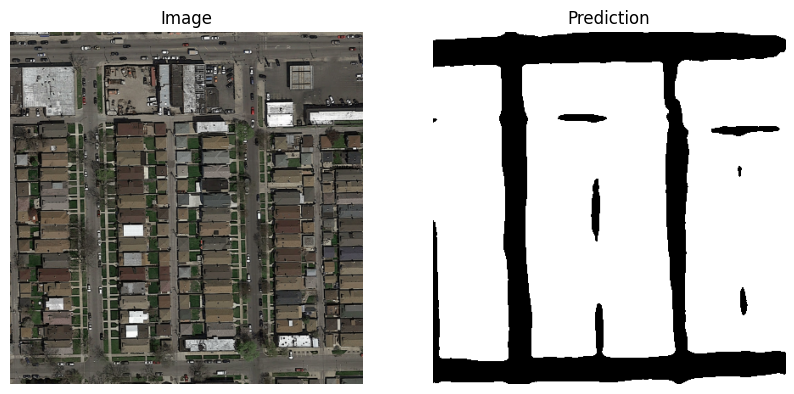

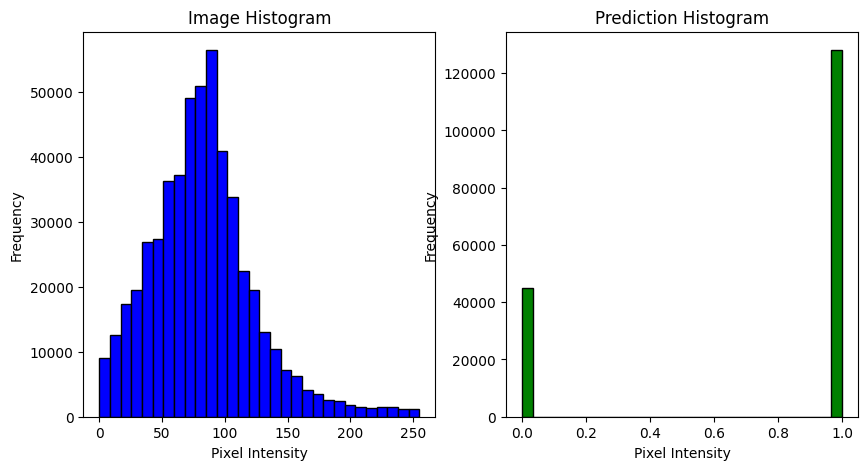

./data/test_set_images/test_2/test_2.png
./data/test_set_images/test_2/test_2.png


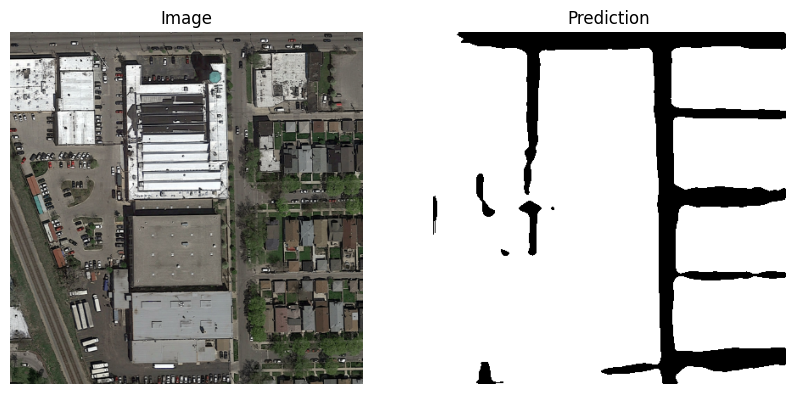

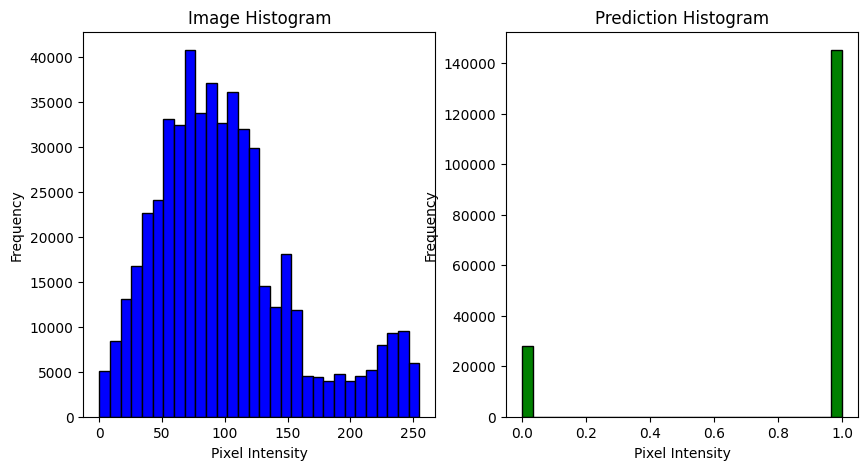

./data/test_set_images/test_3/test_3.png
./data/test_set_images/test_3/test_3.png


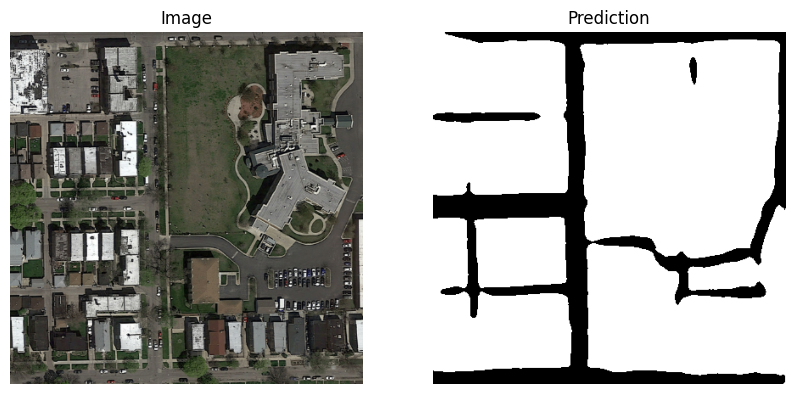

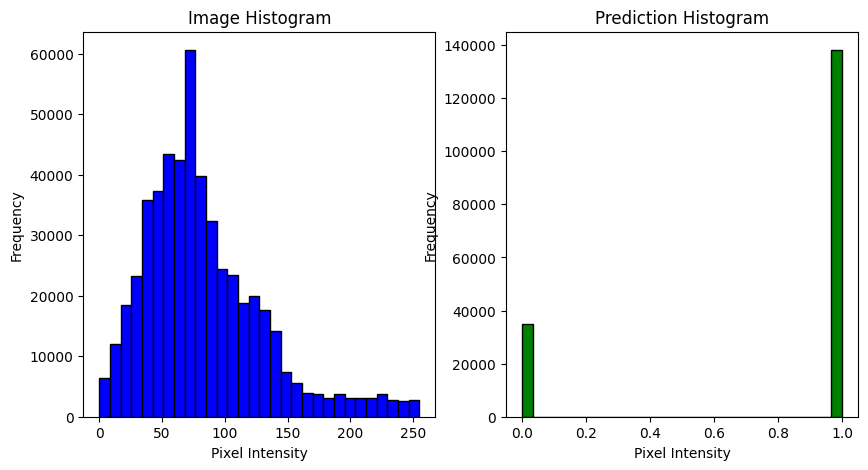

In [ ]:
# Ensure the model is on the correct device and in evaluation mode
test_model = test_model.to(DEVICE)
test_model.eval()
activate_threshold = True
img_nbr = 3
i = 0
# Iterate over all batches in the test_loader
for batch in test_loader:
    i += 1
    with torch.no_grad():
        # Move input to the device where the model is
        input_tensors = batch[1].to(DEVICE)
        logits = test_model(input_tensors)
        pr_gts = logits.sigmoid()

        # Since there are no ground truth masks, we only visualize the images and predictions
        for img_fp, pr_gt in zip(batch[0], pr_gts):  # batch[0] should contain the file paths
            print(img_fp)
            img = cv2.imread(img_fp)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (416, 416))

            # Get the prediction as a numpy array
            pr_gt_cpu = pr_gt.cpu().numpy().squeeze()
            if activate_threshold:
              pr_gt_cpu[pr_gt_cpu >= foreground_threshold] = 1
              pr_gt_cpu[pr_gt_cpu < foreground_threshold] = 0

            plt.figure(figsize=(10, 5))

            plt.subplot(1, 2, 1)
            plt.imshow(img)  # No need to transpose axes since img is read with cv2 and already in HWC format
            plt.title("Image")
            plt.axis("off")

            plt.subplot(1, 2, 2)
            plt.imshow(pr_gt_cpu, cmap='gray')  # Show the prediction
            plt.title("Prediction")
            plt.axis("off")

            # Plot histogram for the image
            plt.figure(figsize=(10, 5))
            plt.subplot(1, 2, 1)
            plt.hist(img.flatten(), bins=30, edgecolor='black', color='blue')
            plt.title('Image Histogram')
            plt.xlabel('Pixel Intensity')
            plt.ylabel('Frequency')

            # Plot histogram for the prediction
            plt.subplot(1, 2, 2)
            plt.hist(pr_gt_cpu.flatten(), bins=30, edgecolor='black', color='green')
            plt.title('Prediction Histogram')
            plt.xlabel('Pixel Intensity')
            plt.ylabel('Frequency')

            plt.show()
    if i == img_nbr:
      break


### .csv File

In [ ]:
output_folder

In [ ]:
import os
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image, to_tensor
from PIL import Image

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
test_model = test_model.to(DEVICE)
foreground_threshold = 0.6  # Threshold for determining foreground vs background

# Parameters for saving images
output_folder = submission_folder + 'eval_imgs/'
os.makedirs(output_folder, exist_ok=True)

# Iterate over the DataLoader
for i, (path, image) in enumerate(test_loader):
    # print("Processing image:", i)
    path = path[0]
    with torch.no_grad():
        test_model.eval()
        # Move input to the device
        input_tensor = image.to(DEVICE)
        logits = test_model(input_tensor)
        # Apply sigmoid to get probabilities
        probabilities = torch.sigmoid(logits)
        # Squeeze to remove unnecessary dimensions
        probabilities = probabilities.squeeze(0).squeeze(0)
        # Apply threshold to the probabilities to binarize
        prediction_binarized = (probabilities < foreground_threshold).float()

        # Convert the binarized prediction to a PIL image
        prediction_pil = to_pil_image(prediction_binarized)

        # Resize the PIL image to 608x608
        prediction_pil_resized = prediction_pil.resize((608, 608), Image.NEAREST)

        # Save the image
        image_num = path.split('/')[-1].split('_')[-1].split('.')[0]
        image_num = int(image_num)
        filename = "test_eval_" + '%.3d' % image_num + '.png'
        prediction_pil_resized.save(os.path.join(output_folder, filename))
        # print(f"Saved {filename}")


./data/test_set_images/test_1/test_1.png
./data/test_set_images/test_2/test_2.png
./data/test_set_images/test_3/test_3.png
./data/test_set_images/test_4/test_4.png
./data/test_set_images/test_5/test_5.png
./data/test_set_images/test_6/test_6.png
./data/test_set_images/test_7/test_7.png
./data/test_set_images/test_8/test_8.png
./data/test_set_images/test_9/test_9.png
./data/test_set_images/test_10/test_10.png
./data/test_set_images/test_11/test_11.png
./data/test_set_images/test_12/test_12.png
./data/test_set_images/test_13/test_13.png
./data/test_set_images/test_14/test_14.png
./data/test_set_images/test_15/test_15.png
./data/test_set_images/test_16/test_16.png
./data/test_set_images/test_17/test_17.png
./data/test_set_images/test_18/test_18.png
./data/test_set_images/test_19/test_19.png
./data/test_set_images/test_20/test_20.png
./data/test_set_images/test_21/test_21.png
./data/test_set_images/test_22/test_22.png
./data/test_set_images/test_23/test_23.png
./data/test_set_images/test_2

In [ ]:
submission_filename = submission_folder + 'test_submission.csv'
image_filenames = []
for i in range(1, 51):
    # image_filename = 'training/groundtruth/satImage_' + '%.3d' % i + '.png'
    image_filename = submission_folder + 'eval_imgs/test_eval_' + '%.3d' % i + '.png'
    image_filenames.append(image_filename)
masks_to_submission(submission_filename, *image_filenames)


In [ ]:
submission_filename

'./submissions/submission_test_run_new_loss2/test_submission.csv'